In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#%load_ext memory_profiler
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
#POPPY
import poppy
from poppy.poppy_core import PlaneType
print("POPPY Version: "+poppy.__version__)
#silence DEBUG and WARNINGs
import logging
logging.getLogger('poppy').setLevel(logging.ERROR)
# MagAO-X function definitions
from model_kit import magaoxFunctions as mf
# for writing files
from datetime import date
print('Last date this notebook was ran: {0}'.format(date.today()))

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

POPPY Version: 0.9.2.dev11+g1887dd5
Last date this notebook was ran: 2021-11-10


In [2]:
# initial conditions
fr_parm = {'wavelength': 656e-9 * u.m,
           'npix': 538, # sample size
           'beam_ratio': 0.25, # oversample
           'leak_mult': 0.01,
           'n_tests': 10,
           'n_loop': 4,
           'set': 0,
           'bump': True,
           'wfe_data': 'common'} # other: 'allopd', 'common'

# set up prescription details
wavelen_str = str(np.round(fr_parm['wavelength'].to(u.nm).value).astype(int))
br = int(1/fr_parm['beam_ratio'])
parm_name = '{0:3}_{1:1}x_{2}nm'.format(fr_parm['npix'], br, wavelen_str)

# set up file locations
home_dir = '/home/jhen/XWCL/code/MagAOX/' # laptop local
data_dir = home_dir + 'data/'

### Data Analysis
Run this only if the data folders are available locally. Otherwise, open the FITS file with the pre-solved data.

In [3]:
%%time
# Build the diffraction limited PSF without vAPP for Strehl calculation

# load the CSV prescription values
rx_loc_difflim = data_dir+'rxCSV/rx_magaox_NCPDM_sci_{0}_noap_{1}.csv'.format(parm_name, 
                                                                              'nowfe')
rx_difflim = mf.makeRxCSV(rx_loc_difflim)

# remove the vAPP
tweeter_num = 16
vappTRANS_num = 23
vappOPD_num = vappTRANS_num+1
rx_difflim['surf_PSD_filename'][vappTRANS_num] = 'none'
rx_difflim['surf_PSD_filename'][vappOPD_num] = 'none'

# apply the bump mask at the coronagraph
rx_difflim[vappTRANS_num]['surf_PSD_folder'] = 'data/mask/'
rx_difflim[vappTRANS_num]['surf_PSD_filename'] = 'bump_mask_vapp'

# calculate in POPPY
magaox = mf.csvFresnel(rx_csv=rx_difflim, 
                       samp=fr_parm['npix'], 
                       oversamp=fr_parm['beam_ratio'],
                       home_folder=home_dir, 
                       break_plane='F69Sci',
                       bump=fr_parm['bump'])
dl_psf = magaox.calc_psf(wavelength=fr_parm['wavelength'].value)[0]
dl_max = np.amax(dl_psf.data)

CPU times: user 57.5 s, sys: 12.7 s, total: 1min 10s
Wall time: 26.7 s


In [4]:
tot_n = 5
tot_sets = tot_n*fr_parm['n_tests']

sr_closed = np.zeros((tot_sets))

n_sr = 0
for j_set in range(0, tot_n):
    # initialize folder for analysis
    fr_folder = 'n{0}_{1}_{2}_cal/'.format(j_set, fr_parm['wfe_data'], fr_parm['npix'])
    
    for j_test in range(0, fr_parm['n_tests']):
        # SR - closed loop version
        sr_loc = 'psf_sr_{0}_s{1}_i4_{2}nm_bump.fits'.format(fr_parm['wfe_data'], j_test, wavelen_str)
        sr_fits = fits.open(fr_folder+sr_loc)[0].data
        sr_closed[n_sr] = (np.amax(sr_fits)/dl_max)
        n_sr += 1

In [5]:
np.mean(sr_closed)

0.9311788860286876

### Save the data

In [7]:
# write fits header
hdr = fits.Header()
hdr['comment'] = 'common optics, fat spider bump mask'
hdr['comment'] = 'closed loop data using thin spider DM solution'
hdr['comment'] = 'psd set: calibrated mvls'
hdr['comment'] = '0th row: strehl'

# write fits file
fits.writeto('data_reduce/fresnelmetric_{0}_closed_calpsd_strehl.fits'.format(fr_parm['wfe_data']), 
             sr_closed, hdr, overwrite=True)

### Figure generating

In [3]:
sr_all = fits.open('data_reduce/fresnelmetric_{0}_closed_calpsd.fits'.format('allopd'))[0].data[0] # the 0th row is Strehl
sr_closed = fits.open('data_reduce/fresnelmetric_{0}_closed_calpsd_strehl.fits'.format(fr_parm['wfe_data']))[0].data

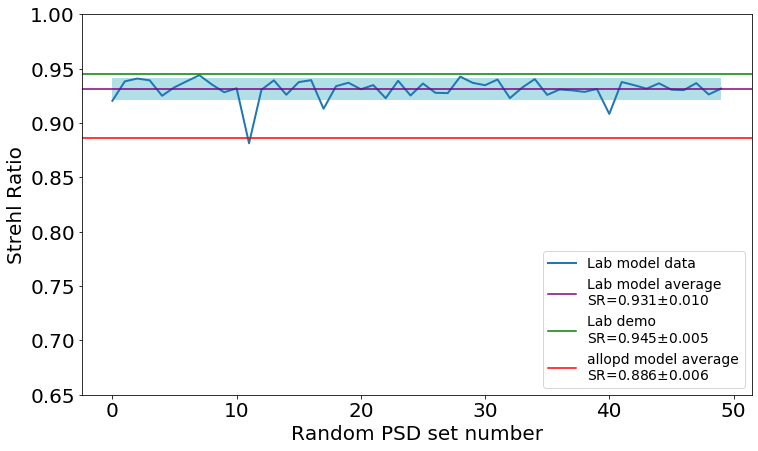

In [7]:
sr_demo = 0.945
tot_sets = sr_all.shape[0]
sr_mean = np.mean(sr_closed)
sr_std = np.std(sr_closed)
x = np.arange(tot_sets)

matplotlib.rcParams["font.size"]=20
plt.figure(figsize=[12,7], facecolor='white')
plt.plot(x, sr_closed, linewidth=2,
         label='Lab model data')
plt.axhline(sr_mean, color='purple', #linewidth=0.75,
            label='Lab model average\nSR={0:.3f}$\pm${1:.3f}'.format(sr_mean, sr_std))
plt.fill_between(x,sr_mean+sr_std,sr_mean-sr_std,
                 facecolor='powderblue', alpha=1.0, edgecolor='none')
plt.axhline(sr_demo, color='green', 
            label='Lab demo \nSR={0:.3f}$\pm$0.005'.format(sr_demo))
plt.axhline(np.mean(sr_all), color='r', 
            label='allopd model average\nSR={0:.3f}$\pm${1:.3f}'.format(np.mean(sr_all),
                                                                         np.std(sr_all)))
plt.ylim(top=1, bottom=0.65)
plt.xlabel('Random PSD set number')
plt.ylabel('Strehl Ratio')
#plt.title('Strehl ratio stats (allopd optics)')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend(loc='lower right', fontsize='x-small')
#plt.title('Strehl (common optics, bump mask, calibrated psd)')

In [5]:
sr_std

0.010000279472702276

### Sample PSF plotter
While the data is still present! Don't run this if the data has already been removed for harddrive space allocation.

Text(0.5, 0, '$\\lambda$/D')

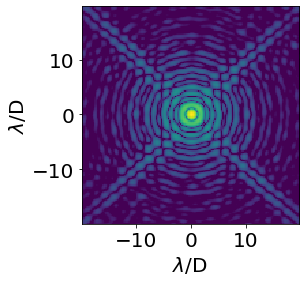

In [29]:
# inspect the psf real quick
j_set = 4 # n
j_test = 9 # s
fr_folder = 'n{0}_{1}_{2}_cal/'.format(j_set, fr_parm['wfe_data'], fr_parm['npix'])
sr_loc = 'psf_sr_{0}_s{1}_i4_{2}nm_bump.fits'.format(fr_parm['wfe_data'], j_test, wavelen_str)
psf_fits = fits.open(fr_folder+sr_loc)[0]
psf_hdr = psf_fits.header
sr_psf = psf_fits.data
sr_psf = sr_psf/np.max(sr_psf)

# crop the psfs one more time
boxsize = 80
src_crop = poppy.utils.pad_or_crop_to_shape(sr_psf, (boxsize*2, 2*boxsize))

# setting the values for lambda/d
fnum_det = 69
platescl = 206265*u.arcsec / (psf_hdr['DIAM']*u.m * fnum_det)
LD_scale = (1/platescl) * (1/(psf_hdr['PIXELSCL'] * u.m / u.pix)) * (psf_hdr['DIFFLMT'] * u.arcsec)
rk = np.linspace(-boxsize, boxsize, (boxsize*2), endpoint=False) * u.pix
rks = (rk / LD_scale).value

vmin = -4.8
vmax = 0

plt.imshow(np.log10(src_crop), origin='lower', 
           extent=[np.amin(rks), np.amax(rks), np.amin(rks), np.amax(rks)],
           vmin=vmin, vmax=vmax)
plt.ylabel('$\lambda$/D')
plt.xlabel('$\lambda$/D')